#**TBANLT 570 - PROJECT 1 - CATEGORIZING DOCUMENTS USING TF-IDF SCORE**
##Overview
In this project, you will use Python to process the textual content of a large collection of news articles with the goal of accurately predicting the correct category for all articles whose categories are currently unknown. To do this, you will compute a feature vector that is composed of term frequency – inverse document frequency (TF-IDF) scores for each news article. You will then be able to compute an average TF-IDF feature vector (i.e., a centroid) for each article category. These TF-IDF category centroids will be used as a basis for calculating the distance between each possible category and each article for which the true category is unknown. You will then use the resulting distance values to predict the correct category for each of these articles.

##Data
The data for this project have been provided to you on the course website in the form of a SQLite database. The database consists of just one Article table whose structure is shown in the entity-relationship diagram to the right. The columns contained in the Article table are:

1. id – Primary key. Uniquely identifies each news article in the table.
Data type: integer.
2.category – The textual name of the category to which each article
belongs. Data type: varchar(25). The set of categories includes:
o Business (270 articles)
o Entertainment (197 articles)
o Politics (239 articles)
o Sports (294 articles)
o Technology (225 articles)
o Unknown (1000 articles)
3. raw_text – The raw text of each news article. Data type: text.

### Import Libraries
Python has a small core set of capabilities with a very large set of libraries. This allows us to import specialized functionality into our programs on an as-needed basis.

Run the code cell below to import all of the libraries that we'll need for this lab assignment.

In [ ]:
#import libraries
import numpy as np #used to quickly perform mathematical calculations on vectors
import pandas as pd #allows us to work with data using Pandas dataframes
import re #regular expressions; used in this assignment to clean the text data
import sqlite3 #used to interact with the database
from collections import Counter #used to quickly count letters and words

In [ ]:
#open a connection to the database
conn = sqlite3.connect('Project 01 - Database.db')

#load all documents into a Pandas dataframe named 'df', and use the 'document_id' column as the index
sql = 'SELECT * FROM Article'
df = pd.read_sql_query(sql, conn)

#close database connection
conn.close()

In [ ]:
df.category.unique()


### Prepare Data for Analysis

In [ ]:
#define a function that will clean the raw input text in preparation for analysis
def clean_text(raw_text):
  #convert the raw text to lowercase
  text = raw_text.lower()
  #remove all numbers from the text using a regular expression
  text = re.sub(r'[0-9]', ' ', text)
  #remove punctuation url etc etc
  text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
  #remove all underscores from the text
  text = re.sub(r'\_', ' ', text)
  #remove anything else in the text that isn't a word character or a space (e.g., punctuation, special symbols, etc.)
  text = re.sub(r'[^\w\s]', ' ', text)
  #remove any excess whitespace
  for _ in range(10): text = text.replace('  ', ' ')
  #remove any leading or trailing space characters
  text = text.strip()
  #return the clean text
  return text


#clean the raw text of each document and store the resulting clean text in a new column 
#in each dataframe. The code below uses a Python feature known as 'list comprehension'
#to quickly handle this task. The code on the right side of the equals sign returns a 
#list, and that list is then used to create a new column in one of the language-specific
#dataframes.
df['clean_text'] = [clean_text(raw_text) for raw_text in df.raw_text]

#show the cleaned text of the first English-language document
df.iloc[0].clean_text


In [ ]:
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
lemmatizer = nltk.stem.WordNetLemmatizer()
wordnet_lemmatizer = WordNetLemmatizer()
stop = stopwords.words('english')


def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)



# Lemmatizing
df['clean_text'] = df['clean_text'].apply(lambda x: lemmatize_sentence(x))
df.head()

###Build a Vocabulary
Our next task will be to build a vocabulary for our English-language corpus. In Natural Language Processing (NLP), a ***vocabulary*** is a collection of unique lexical units appearing in a corpus. Importantly, what constitutes a "lexical unit" can vary from project to project. For our current lab assignment, we will adopt the simplest approach and use the collection of unique ***words*** as the lexical units for our vocabulary, but this is not the only option. Alternatives include:
* <u>Lexemes</u>: A ***lexeme*** is the collection of different forms for a single root word. For example, *eat*, *eats*, *ate*, *eating*, and *eaten* are all part of the same lexeme. A ***lemma*** (e.g., *eat*) is chosen to represent each lexeme, and the lemma appears as the lexeme's headword in a dictionary.
* <u>Lexical Items</u>: A ***lexical item*** is a word or group of words that conveys a single meaning. For example, individual words such as *dog* and *computer* are lexical items, but so are compounds such as *post office* and *parking lot*. Idioms are also lexical items because they convey a single meaning. For example, idioms such as *once in a blue moon* or *finding a needle in a haystack* convey a single meaning, and are hence lexical items.
\?

In [ ]:
#build a vocabulary of words
all_text = ' '.join(df.clean_text) #join all of the English texts into one big string
words = all_text.split() #split the text into words
word_frequencies = Counter(words) #count all words in the text
vocabulary = list(word_frequencies.keys()) #get a list of all unique words

#sort the vocabulary to ensure that we all get consistent results!
vocabulary.sort()

#use slicing to show the first 20 words in the vocabulary
vocabulary[:20]

###Compute Raw Vocabulary Word Frequencies and Total Word Counts for Each Document
Next, let's calculate each document's raw vocabulary word frequencies and total word count. These values will be needed in order to compute the standardized probability for each word in each document.

Run the code cell below to compute the raw vocabulary word frequencies and total word count for each document in the corpus. After computing these values, they will be added to the dataframe as new columns. Read the comments in the code cell carefully to ensure that you understand how the vocabulary word frequencies for each document are being calculated.

In [ ]:
#ensure that the vocabulary is sorted
vocabulary.sort()
#define a collection (list) to hold the raw frequencies for each word in each document
document_word_frequencies = []
#define a collection (list) to hold the total number of words in each document
document_total_words = []
#compute the word frequencies and total number of words for each document in the English-language corpus
for current_document in df.itertuples(): #for each document (row) in the English-language dataframe
  words = current_document.clean_text.split() #split the (clean) text for the current document into words
  total_words = len(words) #compute the total number of words in the document
  #identify all unique words in the document's (clean) text, and count how many times each
  #word appears in the document
  word_frequencies = Counter(words)  
  #compute the document's raw word frequencies for every word in the VOCABULARY (as opposed to every
  #word in the document). The vocabulary will contain more unique words than the document itself, but 
  #we still need to consider EVERY word in the vocabulary, even if a particular word in the vocabulary 
  #doesn't appear in the document. This will ensure that the feature vectors we'll use to represent each
  #document will all be exactly the same length and will have exactly corresponding elements!
  vocabulary_word_frequencies = []
  #for each word in the vocabulary
  for vocabulary_word in vocabulary:
    #if this vocabulary word appears in the document
    if vocabulary_word in word_frequencies:
      #add the number of times this vocabulary word appears in the document to the collection
      vocabulary_word_frequencies.append(word_frequencies[vocabulary_word])
    else: #if this vocabulary word doesn't appear in the document
      #add a value of zero for this vocabulary word to the collection (since this
      #vocabulary word appears zero times in the current document)
      vocabulary_word_frequencies.append(0)      
  #add this document's vocabulary word frequencies to the collection
  document_word_frequencies.append(np.array(vocabulary_word_frequencies) / total_words)
  #add this document's total number of words to the collection
  #document_total_words.append(total_words)

#add the raw word frequencies and total word counts for each document to the
#English-language dataframe as new columns.
df['word_frequencies'] = document_word_frequencies
#df['total_words'] = document_total_words

#show the first few rows in the dataframe
df.head()

In [ ]:
import math
idf_scores =[]
N=df.shape[0]

for word in vocabulary:
  N_w = 0

  for article_text in df.clean_text:
    if word in article_text:
       N_w = N_w + 1

idf_scores.append(math.log(N / N_w))

In [ ]:

df['tfidf_scores'] = [tf_scores * np.array(idf_scores) for tf_scores in df.word_frequencies]



In [ ]:
df.head()
  

In [ ]:
#define a dictionary that holds each category's name (keys) and average word probability distribution (values).
#The probability distributions are all numpy arrays of the same size as the vocabulary. All elements of each
#probability distribution are initialized to zero.
category_distributions = {'Politics': np.zeros(len(vocabulary)), 'Sports': np.zeros(len(vocabulary)), 'Business': np.zeros(len(vocabulary))
, 'Technology': np.zeros(len(vocabulary)), 'Entertainment': np.zeros(len(vocabulary))}
#define a dictionary to hold the number of documents for each category
document_counts = {'Politics': 0, 'Sports': 0, 'Business': 0, 'Technology': 0, 'Entertainment': 0}
#for each document in the corpus
for current_document in df.itertuples():
  #if the category of this document is known
  if current_document.category != 'Unknown':
    #increment the document count for this category
    document_counts[current_document.category] += 1
    #add this document's word probabilities to the running sum for the corresponding distribution 
    #for the document's category
    category_distributions[current_document.category] += current_document.tfidf_scores
#compute the average word probability distributions for each category by dividing the summed probabilities
#by the number of documents for each category
for category in category_distributions:
  category_distributions[category] /= document_counts[category]

###Distance Between Vectors
One of the easiest ways of determining how similar documents are to each other is to measure the distance between their feature vectors. To do this, we simply need to think of each feature vector as defining a location in a multidimensional geometric space. If our vocabulary only contained three unique words, then this would be a three-dimensional space. Our vocabularly contains thousands of unique words, however, so our geometric space will contain thousands of dimensions (one dimension for each word in the vocabulary). This is not a problem, because the Euclidean distance formula applies to geometric spaces with as many dimensions as we need, even if we humans can only intuitively understand spaces that have one, two, or three dimensions. You can learn more about the Euclidean distance formula in [this article](https://en.wikipedia.org/wiki/Euclidean_distance). 

The formula for calculating the Euclidean distance between any two points *p* and *q* in an *n*-dimensional space is:

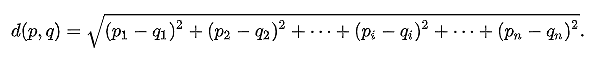

Run the code cell below to define a function that can compute the distance between any two points:

In [ ]:
#define a function to compute the Euclidean distance between two points 
#(where each point is defined as a vector)
def get_distance(point1, point2):
  return np.sqrt(np.sum(np.square(point1 - point2)))

Now that we have our `get_distance()` function, we can easily measure the distance between documents or categorys. Smaller distance values indicate that the documents or categorys are closer to each other (and are hence more similar), while larger distance values indicate that the documents or categorys are farther away from each other (and are hence less similar).

###Distance Between categorys

Run the code cell below to compute the distance between the `Science` and `Sports` categorys.

In [ ]:
#compute and display the distance between the 'Science' and 'Sports' categorys
distance = get_distance(category_distributions['Business'], category_distributions['Sports'])
print('The distance between the "Science" and "Sports" categorys is:', distance)

###Classify Documents with Unknown categorys
Finally, we're ready to use our unigram probability distributions to classify the documents in the corpus that do not currently have a category.



In [ ]:
unknown_df = df.loc[df['category'] == 'Unknown']

In [ ]:
df

In [ ]:
output=[]
#for each document in the English-language corpus
for current_document in unknown_df.itertuples():
  #if the category for this document is unknown
  if current_document.category == 'Unknown':

    min_distance = np.inf
    best_category = ''
    for category_name in category_distributions:
      current_distance = get_distance(current_document.tfidf_scores, category_distributions[category_name])
      if current_distance < min_distance:
        min_distance = current_distance
        best_category = category_name
    output.append(best_category)
unknown_df['predicted'] = output

In [ ]:
unknown_df.head()

In [ ]:
unknown_df.to_csv('Teja, Alluru-01.csv',
columns=['id', 'predicted', 'raw_text' ],index=True, header=False)

## End of Lab Assignment 02!